<a href="https://colab.research.google.com/github/thunder913/Deep-Learning/blob/main/stocks_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
import kagglehub
import numpy as np
import os
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import pickle
import sys
import pdb
import tensorflow as tf
import keras
import random
import yfinance as yf

from numpy.lib.stride_tricks import sliding_window_view
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization, AdditiveAttention, Multiply, Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import load_model
import warnings
from sklearn.metrics import mean_squared_error

warnings.simplefilter("ignore", category=DeprecationWarning)

# Stock Price Prediction usign LSTM

by Andon Gorchov (@thunderman913)

## Abstract

Stock market prediction is a very challenging task, due to the high volatility and nonlinear financial data. Many people try to "beat" the market, but it is a difficult task, even for the Wall Street traders. In this project, we develop a deep learning model based on Long Short-Term Memory(LSTM), in order to predict stock prices. This type of models should be well-suited for time-series forecasting as they effectively capture long-term dependencies and trends. The model will be trained on historical data with precalculated key technical indicators, as well as feature scaling, attention mechanism and different hyperparameters will be tried. Our goal is to create a model, that predicts the short-term stock price trends. The model will be only technical indicators, so in the future it can be extended with market sentiment analysis, economic factors and financial data.

## 1. Problem Definition

To predict the stock market is a very challenging century old task, that has not yet been perfected. If anyone can foresee the stock prices, he would for sure be very wealthy, since it is a very dynamic enviornment. The goal of the project is to create a good enough LSTM model, that predicts the stock price in the short-term. We will experiment with different hyperparameters and models. The data, that will be used is 23 million rows of stock data. We will feature engineer different technical indicators such as RSI, MACD and moving averages in order to predict the most correct price. I am not expecting the model to predict very accurately to the actual price, due to the volatility of the stock data, but I expect it to manage to follow the trend and give close to real values.

There have been numerous studies [1.2, 3], that have explored this topic using LSTM and many other neural network setups. Many of them have shown promise, but they often face challenges such as overfitting due to noise in stock data, high computational demands and difficulties in generalizing accross different stocks. In this work, we will aim to address these limitation by refining the existing approaches and improving them, enhancing their robustness and efficiency.

## 2. Data analysis and tidying

We will need a big stock dataset, in order for the model to predict different tickers accurately. We will be using tihs one:

https://www.kaggle.com/datasets/tsaustin/us-historical-stock-prices-with-earnings-data

It contains daily stock price information for more than 7000 tickers. For our training purposes we will only use tickers with data, that has at least 100 days of information, which is around 7600 tickers and in total of 23 million rows of data, which are from 1998 to mid 2021 Apart from the given data, there will be some feature engineered variables, that we will look into.

In the project we will be using pickles, in order not to download the dataset every time. Also all the fitted models are going to be stored in pickles.

At first let's define path variables, depending on the running enviornment.

All the fitting of the models will be done on google colab, since it will be very time consuming to use my local machine. All the files will be saved to the google drive, when running on colab and locally, when run locally.

In [125]:
if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    base_path = './drive/MyDrive/stocks_lstm'
else:
    base_path = 'pickles'

path = kagglehub.dataset_download("tsaustin/us-historical-stock-prices-with-earnings-data")

stock_prices_path = f"{path}/stocks_latest/stock_prices_latest.csv"

stock_data_path = f"{base_path}/stock_data_processed.pkl"
scaler_path = f"{base_path}/scalers.pkl"

data_path = f"{base_path}/scaled_stock_data.pkl"  # Path to store scaled DataFrame

sequence_length = 30

numerical_columns = [
    'close_adjusted', '5_day_MA', '10_day_MA',
    '20_day_MA', '50_day_MA', '100_day_MA', '200_day_MA'
]

Next up let's define some functions for the data processing. At first we will create methods for calculating Relative Strength Index (RSI) and MACD (Moving Average Convergence Divergence). The RSI is a momentum indicator used to measure the speed and change of price movements. Usually below 30 means oversold and above 70 means overbought. MACD is a trend following momentum indicator, that shows the relationship between two moving averages of a stock's price. In our case we will use the most common MACD with short window 12, long window 26 and signal window 9.

In [126]:
def calculate_rsi(ticker_data, period = 14):
    delta = ticker_data['close_adjusted'].diff()

    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / np.where(avg_loss != 0, avg_loss, 1)

    ticker_data['RSI'] = 100 - (100 / (1 + rs))

    return ticker_data

def calculate_macd(ticker_data, short_window=12, long_window=26, signal_window=9):
    # Calculate EMA short and long
    ema_short = ticker_data['close_adjusted'].ewm(span=short_window, adjust=False).mean()
    ema_long = ticker_data['close_adjusted'].ewm(span=long_window, adjust=False).mean()

    # Calculate MACD and Signal Line
    ticker_data['MACD'] = ema_short - ema_long
    ticker_data['Signal_Line'] = ticker_data['MACD'].ewm(span=signal_window, adjust=False).mean()

    return ticker_data

Next up let's define a method for adding the technical indicators to the main dataframe. Apart from calling the above methods, it also calculates moving averages (MA).

Moving averages are a trend following indicator, that smooths out price data to identify the direction of a trend. It helps traders filter out short term price fluctuations and focus on the broader trend.

In [127]:
def process_ticker_data(df):
    """
    Add historical price features for specific days ago for each stock (grouped by ticker).
    Also calculate the peak price and days since the peak price for each stock.
    """

    # Calculate RSI
    df = df.groupby('ticker', group_keys=False).apply(calculate_rsi)

    # Add moving averages
    moving_average_windows = [5, 10, 20, 50, 100, 200] 

    for window in moving_average_windows:
        df[f'{window}_day_MA'] = (
            df.groupby('ticker')['close_adjusted']
            .transform(lambda x: x.rolling(window=window, min_periods=1).mean())
        )

    # Calculate MACD and Signal Line
    df = df.groupby('ticker', group_keys=False).apply(calculate_macd)

    # Remove the first 200 rows for each ticker
    df = df.groupby('ticker').apply(lambda group: group.iloc[200:]).reset_index(drop=True)

    return df

Next up let's create a method for scaling the stock data. We will be using a different minmaxscaler for each ticker, because otherwise the data gets really compressed and the models cannot accurately predict it.

In [128]:
def plot_adjusted_close_histogram(stock_data_tidy, column):
    """
    Plots a histogram of the adjusted close prices as a percentage distribution.

    Parameters:
        stock_data_tidy: DataFrame containing column named "column" from the passed variables.
        column: The column name.
    """
    plt.figure(figsize=(10, 5))

    # Compute histogram weights as percentages
    weights = np.ones_like(stock_data_tidy[column]) / len(stock_data_tidy[column]) * 100

    plt.hist(
        stock_data_tidy[column],
        bins=50,
        weights=weights,
        edgecolor='black',
        alpha=0.7
    )

    plt.xlabel(column)
    plt.ylabel('Percentage (%)')
    plt.title(f'Distribution of {column} (Percentage)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [129]:
def scale_stock_data(stock_data_tidy, numerical_columns, is_test_data = False):
    """
    Scales numerical columns for each stock ticker independently using MinMaxScaler.

    - Loads existing scalers and scaled data if available.
    - Trains and saves new scalers & scaled data if they don’t exist.
    - Returns a new scaled DataFrame without modifying the original.

    Args:
        stock_data_tidy: The input stock data.
        numerical_columns: The numerical column names, that need to be rescaled.

    Returns:
        pd.DataFrame: The scaled stock data.
    """

    if os.path.exists(scaler_path) and os.path.exists(data_path) and not is_test_data:
        print("Loading existing scalers and scaled data...")

        # Load scalers
        with open(scaler_path, "rb") as f:
            scalers = pickle.load(f)

        # Load scaled stock data
        with open(data_path, "rb") as f:
            new_data_tidy_rescaled = pickle.load(f)

        print("Loaded scalers and scaled data from file.")
        return new_data_tidy_rescaled

    # If files don't exist, compute scalers and scaled data
    scalers = {}
    new_data_tidy_rescaled = []
    for ticker in stock_data_tidy['ticker_encoded'].unique():
        print(f"Processing ticker: {ticker}")

        ticker_data = stock_data_tidy[stock_data_tidy['ticker_encoded'] == ticker].copy()

        scaler = MinMaxScaler()
        scalers[ticker] = scaler.fit(ticker_data[numerical_columns])

        scaler_macd = MinMaxScaler(feature_range=(-1,1))
        scaler_rsi = MinMaxScaler()

        ticker_data[['MACD', 'Signal_Line']] = scaler_macd.fit_transform(ticker_data[['MACD', 'Signal_Line']])
        ticker_data['RSI'] = scaler_rsi.fit_transform(ticker_data[['RSI']])
        ticker_data.loc[:, numerical_columns] = scaler.transform(ticker_data[numerical_columns])

        new_data_tidy_rescaled.append(ticker_data)

    new_data_tidy_rescaled = pd.concat(new_data_tidy_rescaled, ignore_index=True)

    if(not is_test_data):
        with open(scaler_path, "wb") as f:
            pickle.dump(scalers, f)

        with open(data_path, "wb") as f:
            pickle.dump(new_data_tidy_rescaled, f)

        print("Saved scalers and scaled data to file.")

    return new_data_tidy_rescaled, scalers

Finally let's create the method for getting the tidied data. It contains all the technical indicators, scaled prices and tickers.

In [130]:
def getTidiedStockData(stock_data=None):
    """
    Read and tidy the stock data dataset. If the processed stock data already exists as a pickle file,
    it loads and returns the data. Otherwise, it processes the raw stock data, cleans it, adds features,
    and saves the tidy data to a pickle file for future use.

    If `stock_data` is provided, it is used instead of reading from `stock_data_path`.
    """

    stock_data_passed = stock_data is not None
    
    if not stock_data_passed:
        # Check if the file exists
        if os.path.exists(stock_data_path):
            print('found pickle')
            numerical_columns.extend(['RSI', 'MACD', 'Signal_Line'])
            with open(scaler_path, "rb") as f:
                scalers = pickle.load(f)
            return pd.read_pickle(stock_data_path), scalers

        # Read the basic data and some tidying
        stock_data = pd.read_csv(stock_prices_path)

    stock_data_tidy = stock_data.copy()

    stock_data_tidy.date = pd.to_datetime(stock_data_tidy.date)
    stock_data_tidy = stock_data_tidy.rename(columns={'symbol': 'ticker'})
    stock_data_tidy = stock_data_tidy.drop(columns=['split_coefficient'], errors='ignore')

    stock_data_tidy = stock_data_tidy.sort_values(by=['ticker', 'date'], ascending=[True, True])

    stock_data_tidy = process_ticker_data(stock_data_tidy)

    stock_data_tidy = stock_data_tidy.drop(columns=['open', 'high', 'low', 'close', 'volume'], errors='ignore')

    # Encode labels
    le = LabelEncoder()
    stock_data_tidy['ticker_encoded'] = le.fit_transform(stock_data_tidy['ticker'])

    stock_data_tidy['day_of_week'] = stock_data_tidy['date'].dt.dayofweek

    stock_data_tidy, scalers = scale_stock_data(stock_data_tidy, numerical_columns, stock_data_passed)
    if not stock_data_passed:
        numerical_columns.extend(['RSI', 'MACD', 'Signal_Line'])

    # Save only if stock_data was not passed
    if not stock_data_passed:
        stock_data_tidy.to_pickle(stock_data_path)

    return stock_data_tidy, scalers


In [131]:
stock_data_tidy, scalers = getTidiedStockData()

Processing ticker: 0
Processing ticker: 1
Processing ticker: 2
Processing ticker: 3
Processing ticker: 4
Processing ticker: 5
Processing ticker: 6
Processing ticker: 7
Processing ticker: 8
Processing ticker: 9
Processing ticker: 10
Processing ticker: 11
Processing ticker: 12
Processing ticker: 13
Processing ticker: 14
Processing ticker: 15
Processing ticker: 16
Processing ticker: 17
Processing ticker: 18
Processing ticker: 19
Processing ticker: 20
Processing ticker: 21
Processing ticker: 22
Processing ticker: 23
Processing ticker: 24
Processing ticker: 25
Processing ticker: 26
Processing ticker: 27
Processing ticker: 28
Processing ticker: 29
Processing ticker: 30
Processing ticker: 31
Processing ticker: 32
Processing ticker: 33
Processing ticker: 34
Processing ticker: 35
Processing ticker: 36
Processing ticker: 37
Processing ticker: 38
Processing ticker: 39
Processing ticker: 40
Processing ticker: 41
Processing ticker: 42
Processing ticker: 43
Processing ticker: 44
Processing ticker: 4

After loading the data, let's see what kind of data we have finally calculated.

So we have the ticker and ticker_encoded. We will pass the ticker as ticker_encoded to the model. We also have the date of the row and based on the date we have day_of_week feature, which in theory is very useful, since some days have higher market volatility than others. We will experiment with it in practice. The last column from the dataset is close_adjusted, which is the final close price of the day.

Next up we have feature engineered the other columns:

- RSI (Relative strength index)
- Moving averages - we will ahve 5, 10, 20, 50, 100 and 200 day moving averages
- MACD and Sginal Line

All of the data has been minmaxscaled to accomodate the model.
We have one minmaxscaler for the price columns - close_adjusted and moving averages.
The MACD and signal line are with a separate scaler, as well as the RSI.

They are done with separate scalers, because if we scaled all the features together, the model might misinterpret their relative importance, since technical indicator values are generally in the range 0 to 1 and scaling them with prices of up to 10 000, would make them very small and harder to find patterns.

Now let's see some distributions, on what we are going to fit the model.

Let's begin with close price

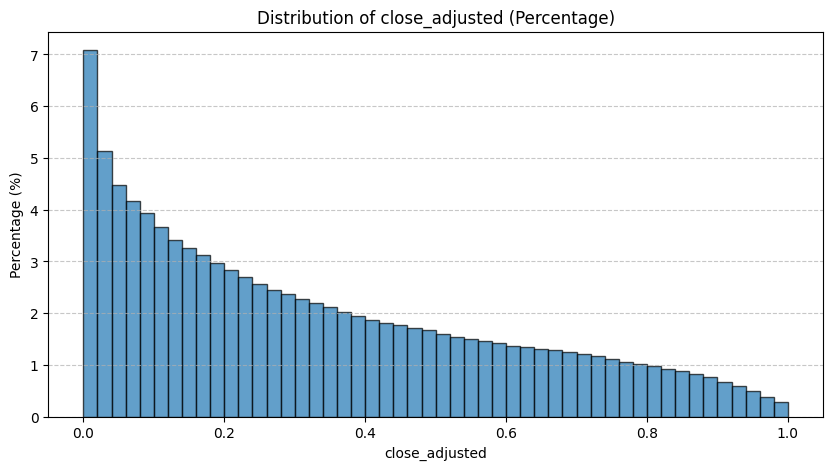

In [132]:
plot_adjusted_close_histogram(stock_data_tidy, 'close_adjusted')

We can observe, that the data is right-skewed, meaning most of the prices are concentrated near 0. This is normal, because we are using data from 1998 to 2021 and in the early years, there we so little companies worth a lot of money. The LSTM model is generally fine with this distribution, because mainly focus on capturing temporal dependencies and not necesserily on exact distributions. We would expect the model to be a little bit more biased on the lower values, that the higher ones.

Let's see some distributions of the technical indicators.

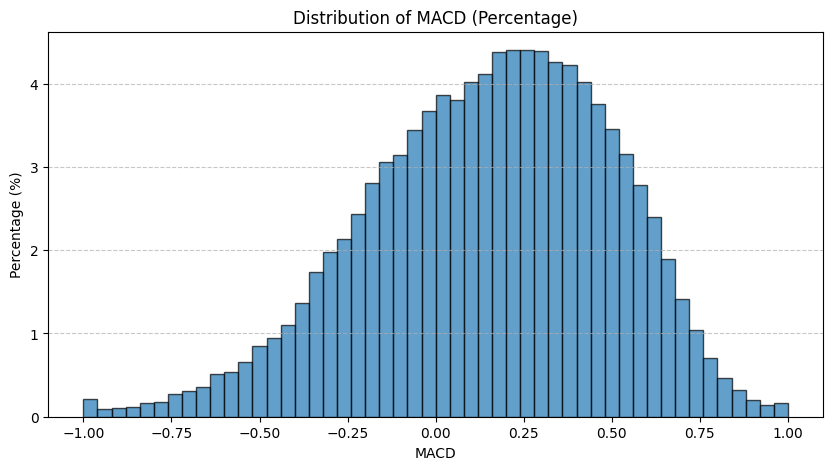

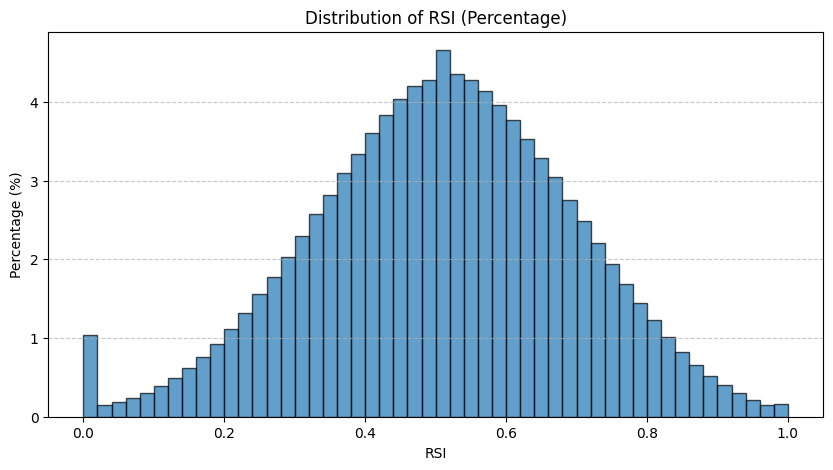

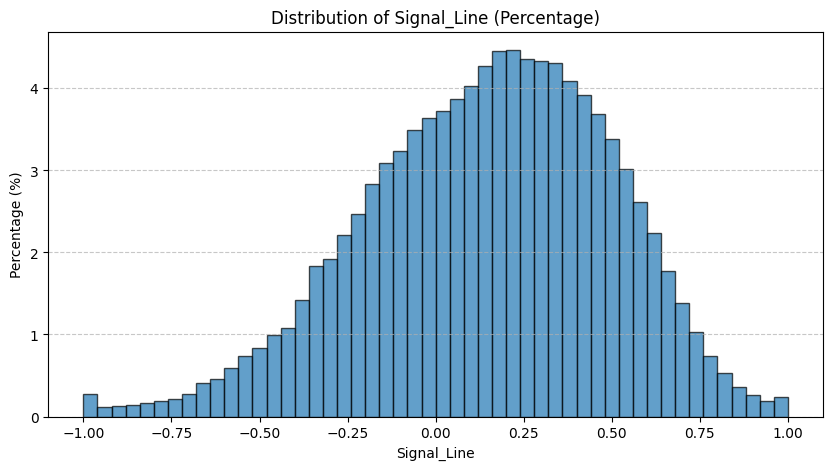

In [133]:
plot_adjusted_close_histogram(stock_data_tidy, 'MACD')
plot_adjusted_close_histogram(stock_data_tidy, 'RSI')
plot_adjusted_close_histogram(stock_data_tidy, 'Signal_Line')


We can see, that all the technical features are properly scaled and they have very simillar distributions, peaking in the middle, which is normal for those indicators. It means the price would not change. We also have some peaks at the lowest values and smaller peaks at the highest ones, which indicate sudden and unexpected price movements.

And finally lets see the moving averages.

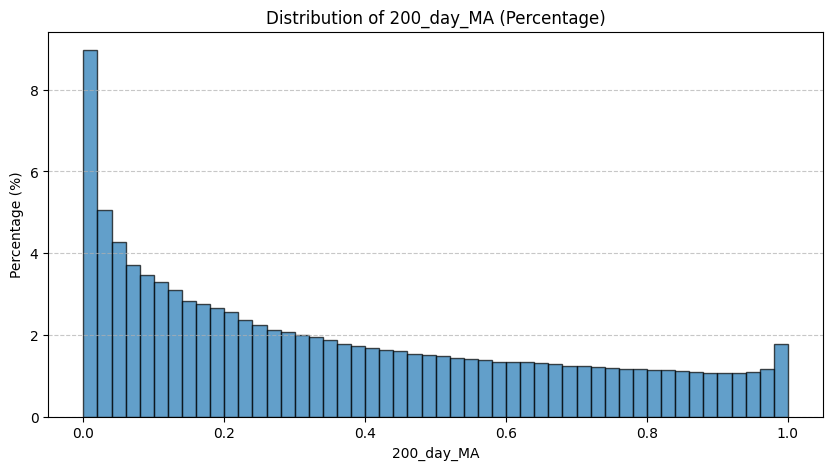

In [134]:
plot_adjusted_close_histogram(stock_data_tidy, '200_day_MA')

As expected they are also right skewed, but also with a small peak near the highest end.

Let's also see, how the moving averages and stock prices look like.

In [135]:
def plot_stock_chart(stock_data_tidy, ticker, start_date, end_date):
    """
    Plots the stock chart with adjusted close prices and moving averages.

    Parameters:
        stock_data_tidy (pd.DataFrame): DataFrame containing stock data.
        ticker (str): Stock ticker symbol.
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.
    """
    # Filter data for the specified ticker and date range
    filtered_data = stock_data_tidy[(stock_data_tidy['ticker'] == ticker) &
                                    (stock_data_tidy['date'] >= start_date) &
                                    (stock_data_tidy['date'] <= end_date)]

    plt.figure(figsize=(14, 7))
    plt.plot(filtered_data['date'], filtered_data['close_adjusted'], label='Close Adjusted', linewidth=1.5)
    plt.plot(filtered_data['date'], filtered_data['5_day_MA'], label='5-Day MA', linestyle='--')
    plt.plot(filtered_data['date'], filtered_data['50_day_MA'], label='50-Day MA', linestyle='--')
    plt.plot(filtered_data['date'], filtered_data['200_day_MA'], label='200-Day MA', linestyle='--')

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'Stock Chart for {ticker} ({start_date} to {end_date})')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

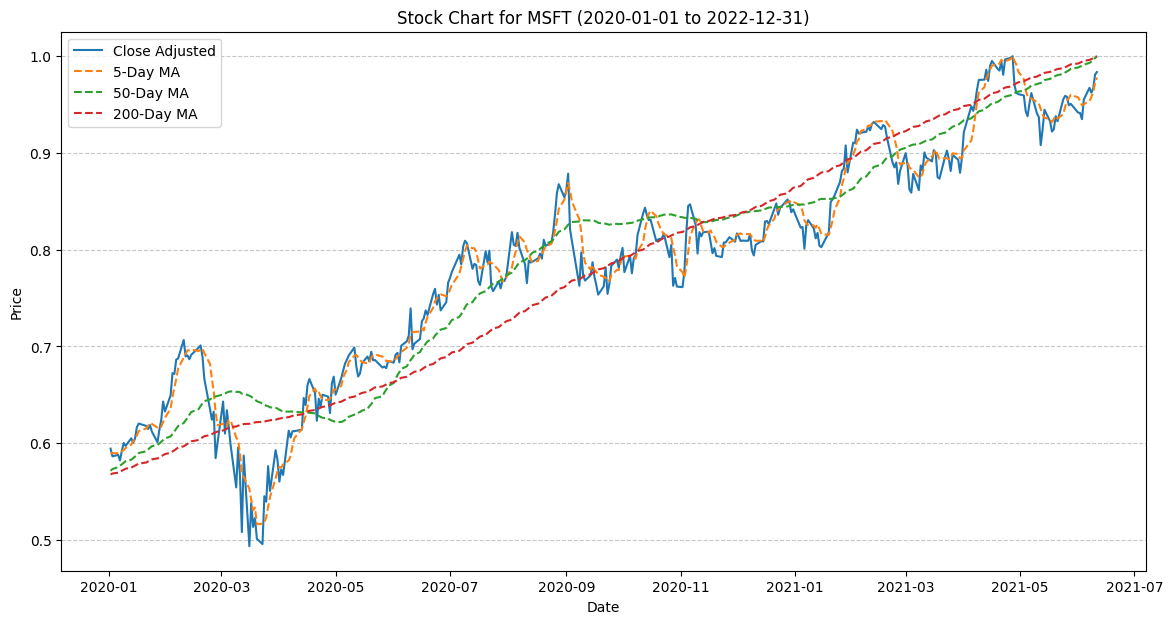

In [136]:
plot_stock_chart(stock_data_tidy, ticker='MSFT', start_date='2020-01-01', end_date='2022-12-31')

Well they seem about right, compared to the actual moving average line for the same period.

## 3. Model Training

During the training we will go through many model generations, most of which will be a complete failure. In this section we will look into the final model training setup. Most of the stuff wasn't used in the early models. In the beginning some of the data wasn't even correct, so that is a reason for not gettin correct predictions obviously. All of the models will be using LSTM, Attention and Dense layers. In the beggining the models didn't even have an attention layer. Maybe let's give some information on what the layers really do.

- LSTM

LSTM are a type of recurrent neural networks designed to handle sequential data and long-term dependencies. They use gates to control the information flow and either keep long term memory or forget the input. They also capture historical movements. [4]

- BatchNormalization

This layer normalizes activations between layers, improving training stability though better learning speeds, regularizing the model and allowing higher learning rates. It helps prevent exploding gradients and reduces the sensitivity of the network to weigh initialization. [5]

- Attention

Attention mechanisms allow the model to focus on the most relevant time steps in the input sequence and instead of treating all historical data points equally, it assigns different importance weights to each past observation. It generally helps the model prioritize recent trends over older less relevant data. It might not be able to generalize all the data, because of that. [6]

- Multiply

It performs element-wise multiplicaiton of tensors. It is used in combination with attention layer to scale input values based on computed attention scores.

- Flatten

It converts a multi-dimensional tensor into a one-dimensional vector. It is placed as transition from LSTM/Attention outputs to a fully connected layer for prediction like the Dense layer.

- Dense

It is a fully connected layer used for final predicitons, where each neuron receives input from all previous layer neurons. The last layer has one neuron, representing the predicted price.

For some loss functions we use Huber. It is a hybrid loss function, that uses uses a threshold to switch between MSE and MAE, reducing the impact of outliers while maintaining sensitivity to small errors. [7] So some of the created models use MSE loss functions, while others use Huber. In the final model, we use the normal MSE, since Huber is less sensitive to extreme errors and it performs more cautious and less aggressive corrections. In the stock trading we usually have a trend and not much of big spikes/crashes. Using huber caused us to have big underestimations from the model.

Below we can see the usual model we will be training on, with different units. Some of the generations will have attention layer, others won't, some will have BatchNormalization, others won't, but in general this is a sample model.

In [137]:
def create_lstm_model(sequence_length, num_features, lstm_units_1=50, lstm_units_2=50, dropout_rate=0.1):
    """
    Optimized LSTM model for stock price prediction with Additive Attention.
    """
    numerical_input = Input(shape=(sequence_length, num_features), name="numerical_input")

    first_lstm_layer = LSTM(lstm_units_1, return_sequences=True, name="lstm_layer_1", dropout=dropout_rate)(numerical_input)
    normalized_1 = BatchNormalization()(first_lstm_layer)

    second_lstm_layer = LSTM(lstm_units_2, return_sequences=True, name="lstm_layer_2", dropout=dropout_rate)(normalized_1)
    normalized_2 = BatchNormalization()(second_lstm_layer)

    # Attention mechanism
    attention = AdditiveAttention(name="attention_layer")([normalized_2, normalized_2])
    attended = Multiply()([second_lstm_layer, attention])

    flat = Flatten()(attended)

    x = Dense(64, activation='relu', name="dense_1")(flat)

    output = Dense(32, activation='relu', name="dense_2")(x)

    output = Dense(1, activation='linear', name="output")(output)

    model = Model(inputs=numerical_input, outputs=output, name="Optimized_LSTM_Model_with_Attention")
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

In [138]:
sample_model = create_lstm_model(sequence_length=sequence_length, num_features=len(numerical_columns))

In [139]:
sample_model.summary()

Model: "Optimized_LSTM_Model_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numerical_input     │ (None, 30, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_1 (LSTM) │ (None, 30, 50)    │     12,200 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 50)    │        200 │ lstm_layer_1[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_2 (LSTM) │ (None, 30, 50)    │     20,200 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 50)    │        200 │ lstm_layer_2[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 30, 50)    │         50 │ batch_normalizat… │
│ (AdditiveAttention) │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 30, 50)    │          0 │ lstm_layer_2[0][… │
│ (Multiply)          │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 1500)      │          0 │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     96,064 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 131,027 (511.82 KB)

 Trainable params: 130,827 (511.04 KB)

 Non-trainable params: 200 (800.00 B)

We can see, that we will at maximum have 2 LSTM layers with BatchNormalization after each one, followed by Attention, Multiply and Flatten layers and finally Dense layers to get the output.

## 3.1. Preparation for training

Let's create some useful methods for the training and afterwards for the model evaluation.

First we are using different scalers for each ticker, let's create a model for easily inversing the predicted data, based on the ticker.

In [140]:
def inverse_transform_predictions(y_pred, ticker):
    columns_to_rescale =  6
    # Use the correct scaler for this ticker
    scaler = scalers[ticker]

    # Inverse transform only the first column (close_adjusted)
    y_pred_rescaled = scaler.inverse_transform(
        np.concatenate((np.array(y_pred).reshape(-1,1), np.zeros((len(y_pred), columns_to_rescale))), axis=1)
    )[:,0]

    return y_pred_rescaled

Next up we will need a method for preprocessing the group data. Since the dataset is massive, it is impossible to keep it all in the memory. We will be using generators to load it from files during the training. For that we will need all the data to be preprocessed and ready.

In [141]:
processed_data_path = base_path + '/processed_data_full/'

def preprocess_grouped_data(stock_data_tidy, numerical_columns, target_column, sequence_length):
    tickers = stock_data_tidy["ticker_encoded"].unique()
    batch_size = 200
    batch_x, batch_y = [], []
    batch_count = 1

    for i, ticker in enumerate(tickers, start=1):
        ticker_data = stock_data_tidy[stock_data_tidy["ticker_encoded"] == ticker].sort_values(by="date")
        numerical_data = ticker_data[numerical_columns].values

        if ticker % 1000 == 0:
            print('Processing ', ticker)

        if len(ticker_data) > sequence_length:
            x_ticker = sliding_window_view(numerical_data[:-1], window_shape=(sequence_length, len(numerical_columns)))
            x_ticker = x_ticker.reshape(-1, sequence_length, len(numerical_columns))
            y_ticker = ticker_data[target_column].values[sequence_length:]

            batch_x.append(x_ticker)
            batch_y.append(y_ticker)

        # Save when we reach 200 tickers
        if len(batch_x) == batch_size or i == len(tickers):
            x_combined = np.concatenate(batch_x, axis=0)
            y_combined = np.concatenate(batch_y, axis=0)

            np.save(os.path.join(processed_data_path, f"x_ticker_batch_{batch_count}.npy"), x_combined)
            np.save(os.path.join(processed_data_path, f"y_ticker_batch_{batch_count}.npy"), y_combined)

            print(f"Saved batch {batch_count}: {x_combined.shape}, {y_combined.shape}")

            # Reset batch storage
            batch_x, batch_y = [], []
            batch_count += 1

    print("Batch processing complete.")

We will be keeping the data in files, each having 200 tickers. I experimented with training the model with one ticker per file, aka having 7600 files, each containing a single ticker preprocessed values, but it was taking too long for the fitting process - around 1 hour per epoch. Having the tickers batched by 200 doesn't increase the required memory by too much and each epoch is now training for 5-6 minutes, which is quite a huge improvement.

In [142]:
stock_data_tidy = stock_data_tidy.sort_values(by=['ticker', 'date'])

if os.path.exists(processed_data_path) and os.path.isdir(processed_data_path):
    has_file = any(os.path.isfile(os.path.join(processed_data_path, item)) for item in os.listdir(processed_data_path))
    if has_file:
        print("There are files in the processed_data_path.")
    else:
      print('Beginning to process the data...\n')
      preprocess_grouped_data(stock_data_tidy, numerical_columns, 'close_adjusted', sequence_length)
else:
    print("The processed_data_path does not exist or is not a directory.")

Beginning to process the data...

Processing  0
Saved batch 1: (597447, 30, 10), (597447,)
Saved batch 2: (553526, 30, 10), (553526,)
Saved batch 3: (586821, 30, 10), (586821,)
Saved batch 4: (664072, 30, 10), (664072,)
Processing  1000
Saved batch 5: (599607, 30, 10), (599607,)
Saved batch 6: (547855, 30, 10), (547855,)
Saved batch 7: (610473, 30, 10), (610473,)
Saved batch 8: (623619, 30, 10), (623619,)
Saved batch 9: (646311, 30, 10), (646311,)
Processing  2000
Saved batch 10: (624665, 30, 10), (624665,)
Saved batch 11: (535559, 30, 10), (535559,)
Saved batch 12: (621310, 30, 10), (621310,)
Saved batch 13: (603365, 30, 10), (603365,)
Saved batch 14: (550547, 30, 10), (550547,)
Processing  3000
Saved batch 15: (572945, 30, 10), (572945,)
Saved batch 16: (490782, 30, 10), (490782,)
Saved batch 17: (635314, 30, 10), (635314,)
Saved batch 18: (574917, 30, 10), (574917,)
Saved batch 19: (639521, 30, 10), (639521,)
Processing  4000
Saved batch 20: (604375, 30, 10), (604375,)
Saved batch 2

## 3.2. Generator

Next up let's create a data_generator method, that will be used to loading the data during the fitting process.

In [143]:
def data_generator(batch_numbers, processed_data_path, batch_size=32):
    """Generates batches dynamically from pre-selected batch numbers."""

    while True:
        random.shuffle(batch_numbers)  # Shuffle batch order

        for batch_num in batch_numbers:
            x_path = os.path.join(processed_data_path, f"x_ticker_batch_{batch_num}.npy")
            y_path = os.path.join(processed_data_path, f"y_ticker_batch_{batch_num}.npy")

            if not os.path.exists(x_path) or not os.path.exists(y_path):
                continue  # Skip missing files

            x_data = np.load(x_path)
            y_data = np.load(y_path)

            # Ensure full batches
            steps_per_epoch = len(x_data) // batch_size
            x_data = x_data[:steps_per_epoch * batch_size]
            y_data = y_data[:steps_per_epoch * batch_size]

            # Shuffle within the batch
            indices = np.arange(len(x_data))
            np.random.shuffle(indices)
            x_data = x_data[indices]
            y_data = y_data[indices]

            # Yield mini-batches
            for i in range(steps_per_epoch):
                x_batch = x_data[i * batch_size: (i + 1) * batch_size]
                y_batch = y_data[i * batch_size: (i + 1) * batch_size]

                yield np.array(x_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)


As we can see we have an infinite while true loop, that ensures the generator wiull go on forever, until the fitting is done or interrupted.

We always shuffle the tickers, ensuring the randomness of the tickers, since we don't want the model training with the same order. Next up, we skip any files, that do not exist or are empty and finally we get the batches and yield the data.

In [144]:
batch_files = sorted([f for f in os.listdir(processed_data_path) if f.startswith("x_ticker_batch_") and f.endswith(".npy")])
batch_numbers = [int(f.split("_")[-1].split(".")[0]) for f in batch_files]

train_batches, test_batches = train_test_split(batch_numbers, test_size=0.05, random_state=42)

print(f"Train batches: {len(train_batches)}")
print(f"Test batches: {len(test_batches)}")


Train batches: 36
Test batches: 2


The above code splits the data into test and train set. We use 5% of the data for testing, since that is sufficent. In our case it is 2 batches, each containing 200 tickers, so in total of 400 tickers will be used for training.

In [145]:
train_gen = data_generator(train_batches, processed_data_path, batch_size=32)
test_gen = data_generator(test_batches, processed_data_path, batch_size=32)

early_stopping = EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)

Finally we create the data generator and also an early stopping mechanism, if the model doesn't improve anymore. We have set it to patience = 10, which means if in 10 epochs, the models doesn't improve, the training will stop.

## 3.3. Predictions visualization

Next up we will need some methods for actually visualizing the prediction and see with our own eyes, how good or bad the model is.

We should have two line in a plot, that visualize the expected vs actual prices. We expect them to be close to each other.

In [146]:
def get_sequences_and_predict(ticker, stock_data, numerical_columns, sequence_length, model):
    """
    Extracts sequences for a given ticker, performs predictions, and returns rescaled values.

    Parameters:
    - ticker: Stock ticker symbol.
    - stock_data: DataFrame containing stock data.
    - numerical_columns: List of numerical feature columns.
    - sequence_length: Length of sequences.
    - model: Trained model for prediction.

    Returns:
    - dates: Pandas Series of date values.
    - y_sequence_rescaled: Rescaled actual stock prices.
    - y_pred_rescaled: Rescaled predicted stock prices.
    """
    ticker_data = stock_data[stock_data.ticker == ticker]

    X = ticker_data[numerical_columns].values
    y = ticker_data['close_adjusted'].values

    X_sequences = []
    y_sequences = []

    for i in range(sequence_length, len(X)):
        X_sequences.append(X[i-sequence_length:i])
        y_sequences.append(y[i])

    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences)

    y_pred = model.predict(X_sequences)

    y_sequence_rescaled = inverse_transform_predictions(y_sequences, ticker_data.ticker_encoded.unique()[0])
    y_pred_rescaled = inverse_transform_predictions(y_pred, ticker_data.ticker_encoded.unique()[0])

    dates = ticker_data['date'].iloc[sequence_length:].reset_index(drop=True)

    return dates, y_sequence_rescaled, y_pred_rescaled

In [147]:
def plot_actual_vs_predicted(dates, y_actual, y_pred, title='Actual vs Predicted Prices'):
    """
    Plots actual vs predicted stock prices.

    Parameters:
    - dates: Pandas Series or list of date values.
    - y_actual: Actual stock prices.
    - y_pred: Predicted stock prices.
    - title: Title of the plot (default: 'Actual vs Predicted Prices').
    """
    plt.figure(figsize=(12, 6))

    plt.plot(dates, y_actual, label='Actual Prices', alpha=0.8)
    plt.plot(dates, y_pred, label='Predicted Prices', alpha=0.8)

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)

    plt.show()


In [148]:
def evaluate_model_on_ticker(ticker, model):
    """
    Calls get_sequences_and_predict() to generate sequences and predictions for a given ticker,
    then calls plot_actual_vs_predicted() to visualize the results.

    Parameters:
    - ticker: Stock ticker symbol (e.g., "TSLA").
    - model: Trained deep learning model.
    """
    dates, y_sequence_rescaled, y_pred_rescaled = get_sequences_and_predict(
        ticker, stock_data_tidy, numerical_columns, sequence_length, model
    )

    plot_actual_vs_predicted(dates, y_sequence_rescaled, y_pred_rescaled)

    return y_sequence_rescaled, y_pred_rescaled


In [149]:
def fetch_stock_data(ticker: str, period: str = "48mo", interval: str = "1d"):
    """
    Fetch historical stock data from Yahoo Finance and return as a Pandas DataFrame.
    
    - param ticker: Stock ticker symbol
    - param period: Time period
    - param interval: Data interval

    Returns:
    - df: Pandas DataFrame with stock data for the given period
    """ 
    stock = yf.Ticker(ticker)
    data = stock.history(period=period, interval=interval)
    df = pd.DataFrame(data)

    df['date'] = df.index.normalize()
    df = df.reset_index(drop=True)

    df['close_adjusted'] = df['Close']
    df = df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits', 'Close'])

    df['symbol'] = ticker

    return df

In [150]:
def calculate_mse_for_stocks(model, stocks=["NVDA", "AAPL", "FL", "NKE", "HPE", "PYPL", "AMD", "VOO"]):
    """
    Calculates the mean squared error in the last 2 years of data, the model was not trained on, for the given stocks

    - param model: The model to get the MSE for
    - param stocks: The stocks to calculate it

    Returns:
    - mse_df: All the mean squared errors
    - average_mse: The average mean squared error
    """
    total_mse = 0
    mse_values = {}

    for stock in stocks:
        df = fetch_stock_data(stock)
        data, _ = getTidiedStockData(df)

        _, y_sequence_rescaled, y_pred_rescaled = get_sequences_and_predict(stock, data, numerical_columns, sequence_length, model)
        mse = mean_squared_error(y_sequence_rescaled, y_pred_rescaled)
        mse_values[stock] = mse
        total_mse += mse

    # Create DataFrame and display results
    mse_df = pd.DataFrame(mse_values.items(), columns=["Stock", "MSE"])
    average_mse = total_mse / len(stocks)

    return mse_df, average_mse

In [151]:
df = fetch_stock_data('AAPL')

data, scaler = getTidiedStockData(df)

Processing ticker: 0


## 4. Models

In order to find the best model, I have gone through a lot of them to find the best models, that manage to predict the data correctly.

We will go from generation to generation and see what the model's state was and what was tried to improve it. Also we will go through all the difficulties and hassles there were - from data, to model improvements and generator improvements. 

## 4.1. First generation

The first generation model had two lstm layers, the first one with 64 units and the second one with 64 as well. We have dropout layers after each LSTM layer, but with a dropout of 0.1, which is a bit on the lower size, compared to our dataset of nearly 23 million rows.

We had only one Dense layer in the end with only one unit, which is generally bad for LSTM models with multiple features. Also stock prices are sort of linear, but not always and having more Dense layers fcan help us with the generalization.

Also in this generation we are passing a bit of wrongly scaled data, having only one scaler for all the features, which after a lot of tweaking, turned out really bad. We are also passing the day_of_week feature, which layer on, I found out is unnecessary.

In [152]:
first_model = load_model(base_path + '/first_gen_model.keras')

In [153]:
first_model.summary()

Model: "LSTM_Stock_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ numerical_input (InputLayer)    │ (None, 30, 11)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_1 (LSTM)             │ (None, 30, 64)         │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_2 (LSTM)             │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,637 (615.77 KB)

 Trainable params: 52,545 (205.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 105,092 (410.52 KB)

178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


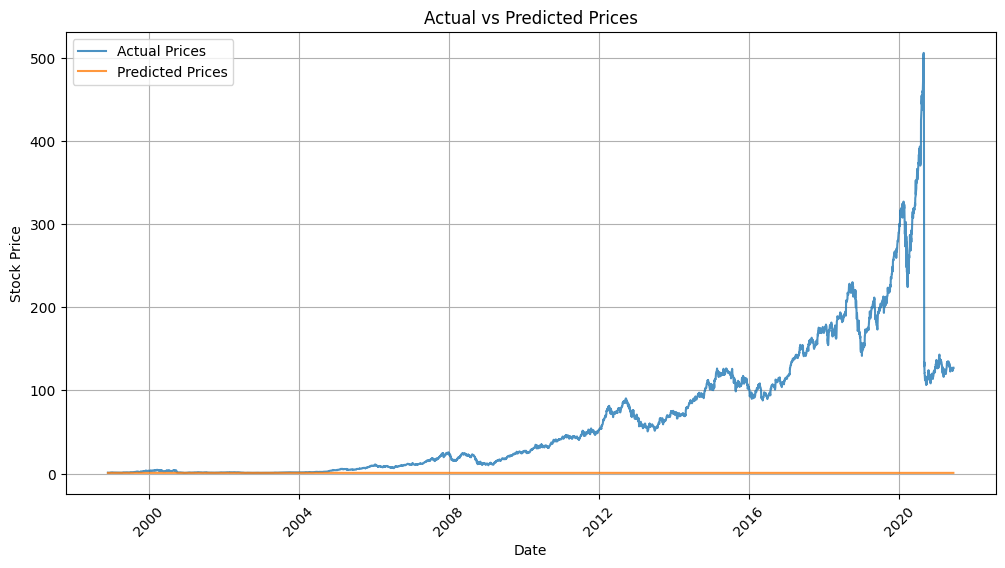

In [154]:
numerical_columns.append('day_of_week')
evaluate_model_on_ticker("AAPL", first_model)
numerical_columns.remove('day_of_week')

As we can see this model in a complete failure, not managing to even slightly follow the trend. Let's see how it improves with the second generation.

## 4.2. Second generation

The second generation model tried had a bit better structure, but still lacked necessary improvements.

The dropout was increasted to 0.2 and also another two Dense layers were added for more accurate prediction. Still the data had some issues, generator was working slow, using two small side LSTM's and huber loss.

Seems like a good model, but not trained correctly, due to using one scaler for both price and technical indicators.

In [155]:
second_model = load_model(base_path + '/second_gen_model.keras')

C:\Users\andon\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [156]:
second_model.summary()

Model: "Optimized_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ numerical_input (InputLayer)    │ (None, 30, 11)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_1 (LSTM)             │ (None, 30, 128)        │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_2 (LSTM)             │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 371,141 (1.42 MB)

 Trainable params: 123,713 (483.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 247,428 (966.52 KB)

178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


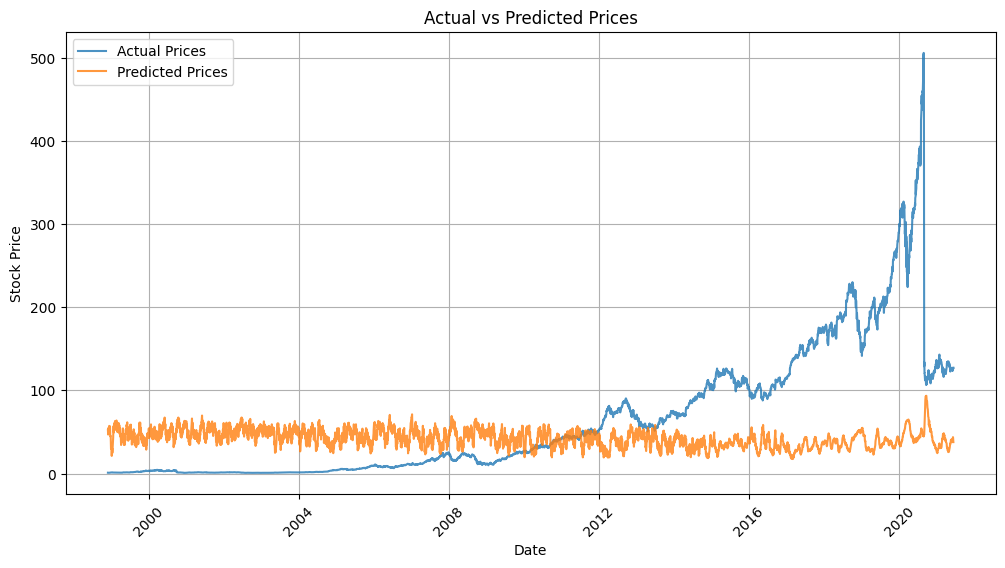

In [157]:
numerical_columns.append('day_of_week')
evaluate_model_on_ticker("AAPL", second_model)
numerical_columns.remove('day_of_week')

Well, we can see that those improvements didn't do much... The prediction is now a wavy line, that has a bit of knowledge of when the data is spiking, but not even close to the real data and that behaviour went for a while.

## 4.3. Third generation

The third model introduced Attention layer and Batch Normalization after the LSTM layers. However there were still some issues with the data and the generators were still for only one ticker, making the training very slow. 

This generation is also the first one to use ticker_encoded, which after some mroe testing, I figured out is unnecessary.

In [158]:
third_model = load_model(base_path + '/third_gen_model.keras')

In [159]:
third_model.summary()

Model: "Optimized_LSTM_Model_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numerical_input     │ (None, 30, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_1 (LSTM) │ (None, 30, 256)   │    275,456 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 256)   │      1,024 │ lstm_layer_1[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_2 (LSTM) │ (None, 30, 128)   │    197,120 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 128)   │        512 │ lstm_layer_2[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_3 (LSTM) │ (None, 30, 64)    │     49,408 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 64)    │        256 │ lstm_layer_3[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 30, 64)    │         64 │ batch_normalizat… │
│ (AdditiveAttention) │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 30, 64)    │          0 │ lstm_layer_3[0][… │
│ (Multiply)          │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1920)      │          0 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │     61,472 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,754,245 (6.69 MB)

 Trainable params: 584,449 (2.23 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 1,168,900 (4.46 MB)

169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step


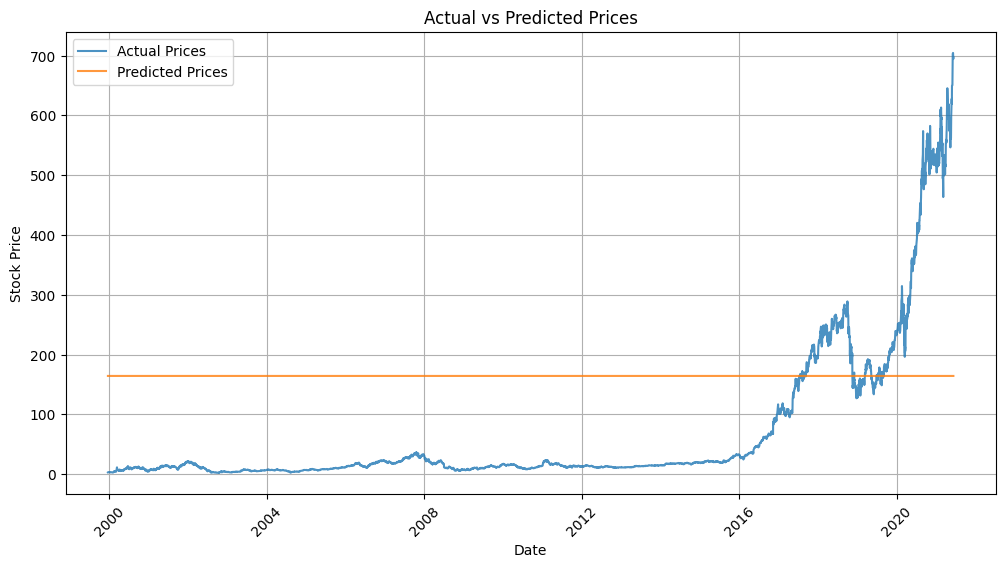

In [160]:
numerical_columns.append('day_of_week')
numerical_columns.append('ticker_encoded')
evaluate_model_on_ticker("NVDA", third_model)
numerical_columns.remove('day_of_week')
numerical_columns.remove('ticker_encoded')

Even after all the improvements, we can see the model is flatlining, which is a big downgrade from the previous model. Then a thought process began, the model seemed like a really good one, but yet the predictions are not even close to being on point. That is the moment, when I figured out having separate scalers for price features and technical indicators is crucial and also passing day_of_week and ticker_encoded to the models is not necessary.

## 4.4. Fourth model

And here we go with the fourth generation model, after figuring out all the data issues and training the exact same model as above.

In [161]:
fourth_model = load_model(base_path + '/fourth_gen_model.keras')

In [162]:
fourth_model.summary()

Model: "Optimized_LSTM_Model_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numerical_input     │ (None, 30, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_1 (LSTM) │ (None, 30, 256)   │    273,408 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 256)   │      1,024 │ lstm_layer_1[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_2 (LSTM) │ (None, 30, 128)   │    197,120 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 128)   │        512 │ lstm_layer_2[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_3 (LSTM) │ (None, 30, 64)    │     49,408 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 64)    │        256 │ lstm_layer_3[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 30, 64)    │         64 │ batch_normalizat… │
│ (AdditiveAttention) │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 30, 64)    │          0 │ lstm_layer_3[0][… │
│                     │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1920)      │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │     61,472 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,165,700 (4.45 MB)

 Trainable params: 582,401 (2.22 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 582,403 (2.22 MB)

In [163]:
# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    filepath=base_path + 'simple_fifth_model_epoch_1_{epoch:02d}.keras',  # Saves model for each epoch
    save_best_only=False,  # Save model at every epoch
    save_weights_only=False,  # Save full model (architecture + weights)
    verbose=1
)

early_stopping = EarlyStopping(monitor="loss", patience=20, restore_best_weights=True)

# Train the model with checkpoint callback
# fourth_model.fit(
#     train_gen,
#     steps_per_epoch=200000//2,
#     validation_data=test_gen,
#     validation_steps=10000//2,
#     epochs=100,
#     callbacks=[checkpoint, early_stopping],  # Include checkpoint callback
#     verbose=1
# )

print("Training complete!")

# fourth_model.save(base_path +"/complex.keras")


Training complete!


178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step


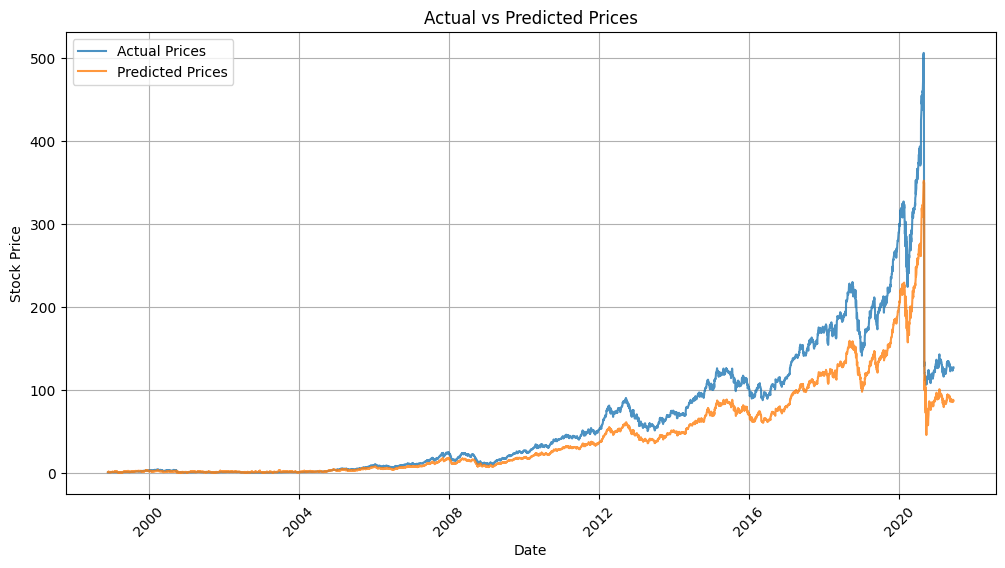

(array([  1.0719,   1.1306,   1.058 , ..., 127.13  , 126.11  , 127.35  ]),
 array([ 1.46404814,  1.6944599 ,  1.47787104, ..., 87.93488977,
        88.38673894, 87.14675871]))

In [164]:
evaluate_model_on_ticker("AAPL", fourth_model)

As we can see, the model is giving almost on point price predictions. Still it is lacking a bit, giving predictions for lower that the actual price, but still it manages to capture the price movement direction, which is a lot better, that the previous models. For this one we will try with actual data, that the model was not trained on.

In [165]:
df = fetch_stock_data('AAPL')

data, scaler = getTidiedStockData(df)

Processing ticker: 0


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


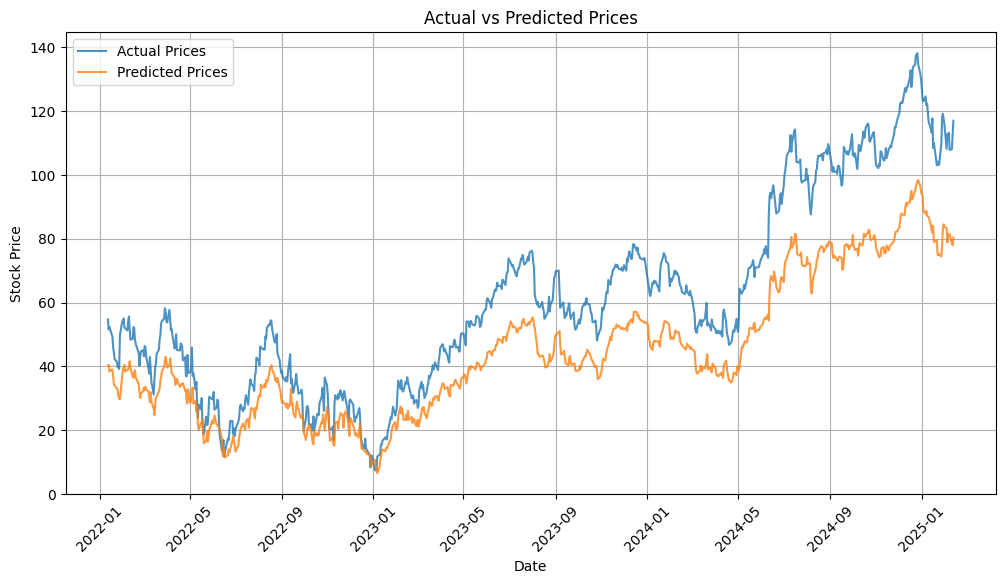

In [166]:
dates, y_sequence_rescaled, y_pred_rescaled = get_sequences_and_predict('AAPL', data, numerical_columns, sequence_length, fourth_model)
plot_actual_vs_predicted(dates, y_sequence_rescaled, y_pred_rescaled)

As we can see the model kinda works on data it has never seen before. It is expecting the same way as with the training set, giving a bit of a lower value, that the actual one.

In [167]:
mse_df, average_mse = calculate_mse_for_stocks(fourth_model)
print('Average MSE: ', average_mse)

Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Average MSE:  303.1228847393763


## Fifth Model

The fifth model, that will be experimented with is one with less number of units to see if having such a big model is necessary. The expection is that the complex one is performing a bit better.

In [168]:
fifth_model = load_model(base_path + '/fifth_gen_model.keras')

In [169]:
fifth_model.summary()

Model: "Optimized_LSTM_Model_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numerical_input     │ (None, 30, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_1 (LSTM) │ (None, 30, 64)    │     19,200 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 64)    │        256 │ lstm_layer_1[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_2 (LSTM) │ (None, 30, 32)    │     12,416 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 32)    │        128 │ lstm_layer_2[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 30, 32)    │         32 │ batch_normalizat… │
│ (AdditiveAttention) │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 30, 32)    │          0 │ lstm_layer_2[0][… │
│                     │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 960)       │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │     15,376 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         17 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 141,893 (554.27 KB)

 Trainable params: 47,233 (184.50 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 94,468 (369.02 KB)

178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


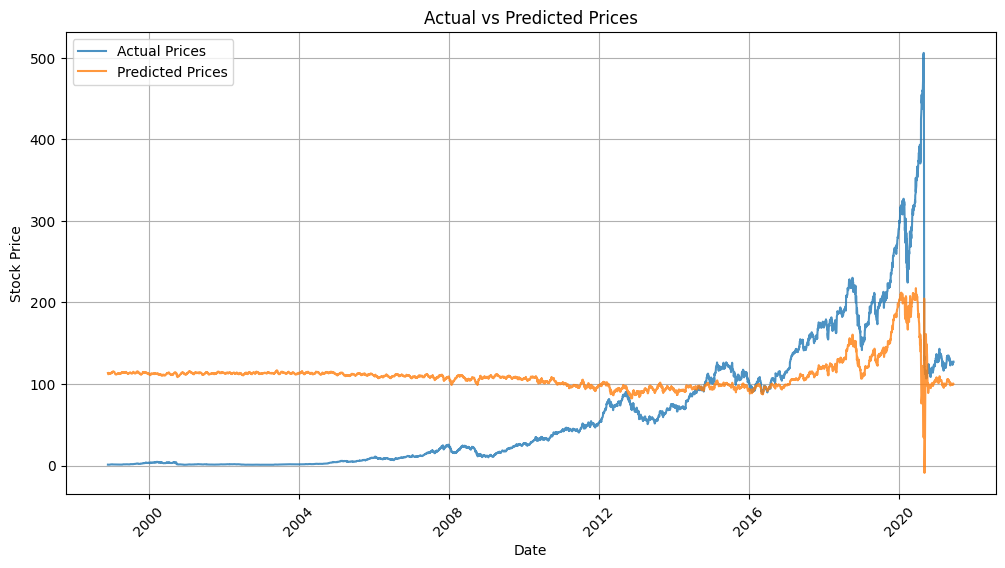

(array([  1.0719,   1.1306,   1.058 , ..., 127.13  , 126.11  , 127.35  ]),
 array([113.43086425, 112.98463158, 112.41522755, ..., 100.49205928,
        100.63463992, 100.16795899]))

In [170]:
evaluate_model_on_ticker("AAPL", fifth_model)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


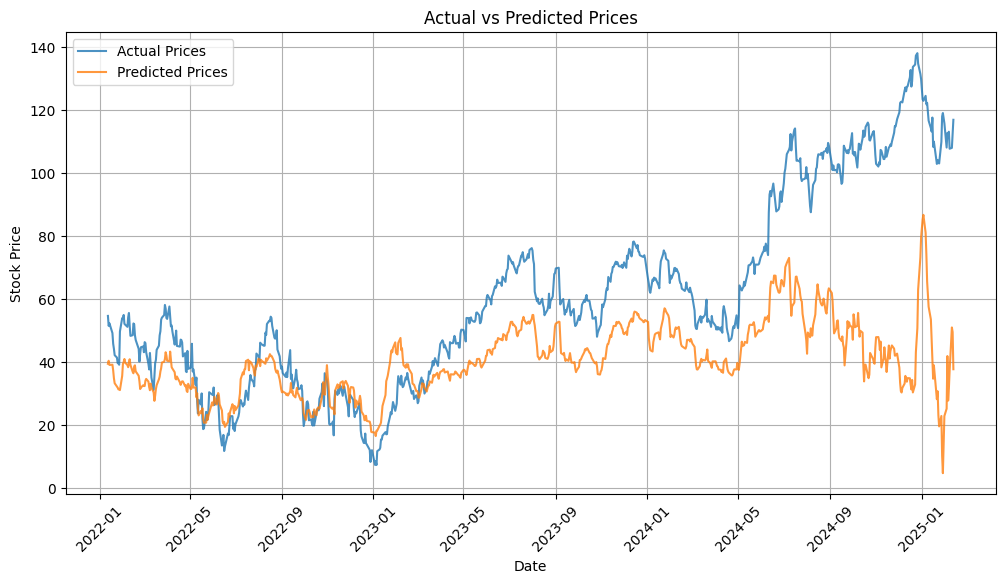

In [171]:
dates, y_sequence_rescaled, y_pred_rescaled = get_sequences_and_predict('AAPL', data, numerical_columns, sequence_length, fifth_model)
plot_actual_vs_predicted(dates, y_sequence_rescaled, y_pred_rescaled)

In [172]:
mse_df, average_mse = calculate_mse_for_stocks(fifth_model)
print('Average MSE: ', average_mse)

Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Average MSE:  817.8163734190457


As we can see from the average MSE, the model is doing much worse than the one with more units.

## Sixth Model

After doing some research I figured out, that it might be useful to remove the Batch normalization layer before the Attention layer. Also I am changing the loss function of the model to be MSE, since huber is not really working well for my model. One reason for that might be, because stock prices have large variability and prices can fluctuate drastically, so the model may underestimate price spikes. Also it discourages the model from making big corrections, so that might be a reason, that we are observing such underestimation.

In [173]:
sixth_model = load_model(base_path + '/sixth_gen_model.keras')

In [174]:
sixth_model.summary()

Model: "Improved_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numerical_input     │ (None, 30, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_1 (LSTM) │ (None, 30, 256)   │    273,408 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 256)   │      1,024 │ lstm_layer_1[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_2 (LSTM) │ (None, 30, 128)   │    197,120 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 128)   │        512 │ lstm_layer_2[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_3 (LSTM) │ (None, 30, 64)    │     49,408 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 30, 64)    │         64 │ lstm_layer_3[0][… │
│ (AdditiveAttention) │                   │            │ lstm_layer_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 30, 64)    │          0 │ lstm_layer_3[0][… │
│ (Multiply)          │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1920)      │          0 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │    122,944 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,938,245 (7.39 MB)

 Trainable params: 645,825 (2.46 MB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 1,291,652 (4.93 MB)

178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step


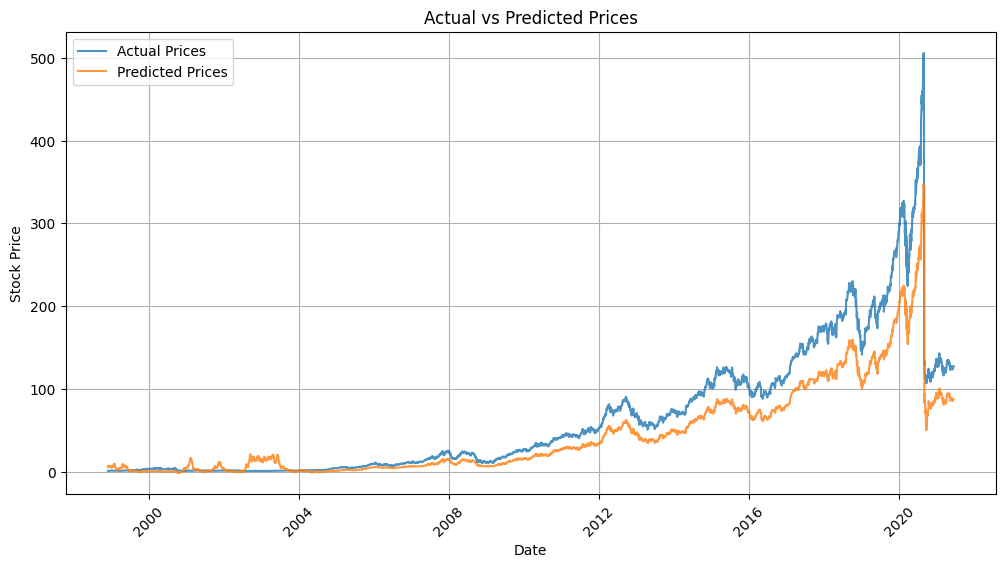

(array([  1.0719,   1.1306,   1.058 , ..., 127.13  , 126.11  , 127.35  ]),
 array([ 5.76190794,  7.01445376,  6.77321557, ..., 88.09956747,
        88.3825755 , 87.7414219 ]))

In [175]:
evaluate_model_on_ticker("AAPL", sixth_model)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


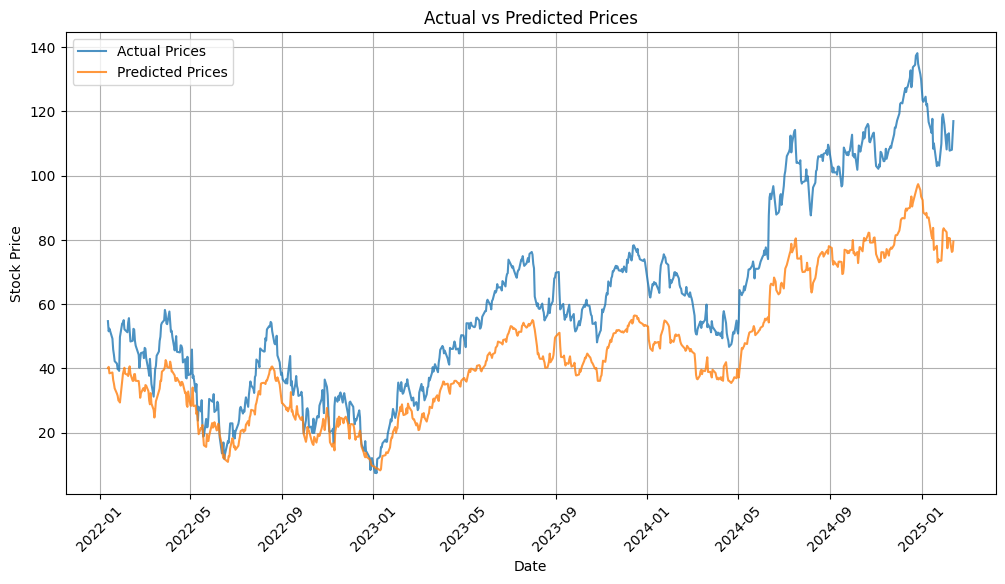

In [176]:
dates, y_sequence_rescaled, y_pred_rescaled = get_sequences_and_predict('AAPL', data, numerical_columns, sequence_length, sixth_model)
plot_actual_vs_predicted(dates, y_sequence_rescaled, y_pred_rescaled)

Well the model still seems to underestimate, without much of a difference, than the fourth model. Let's the MSE.

In [177]:
mse_df, average_mse = calculate_mse_for_stocks(sixth_model)
print('Average MSE: ', average_mse)
display(average_mse)

Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Average MSE:  310.645579372052


310.645579372052

Yeah the model is pretty much the same. Let's do some more experiments.

## Seventh Model

In this model we have removed the Attention layer, because using it makes the model ignore global trends and focus on short-term changes. We are going with the "complex" model of 256, 128 and 64 units per the LSTM layers and 3 Dense layers, each with 64, 32 and 1 units. 

In [178]:
seventh_model = load_model(base_path + '/seventh_gen_model.keras')

In [179]:
seventh_model.summary()

Model: "Improved_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ numerical_input (InputLayer)    │ (None, 30, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_1 (LSTM)             │ (None, 30, 256)        │       273,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 30, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_2 (LSTM)             │ (None, 30, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_3 (LSTM)             │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,582,213 (6.04 MB)

 Trainable params: 527,105 (2.01 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 1,054,212 (4.02 MB)

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


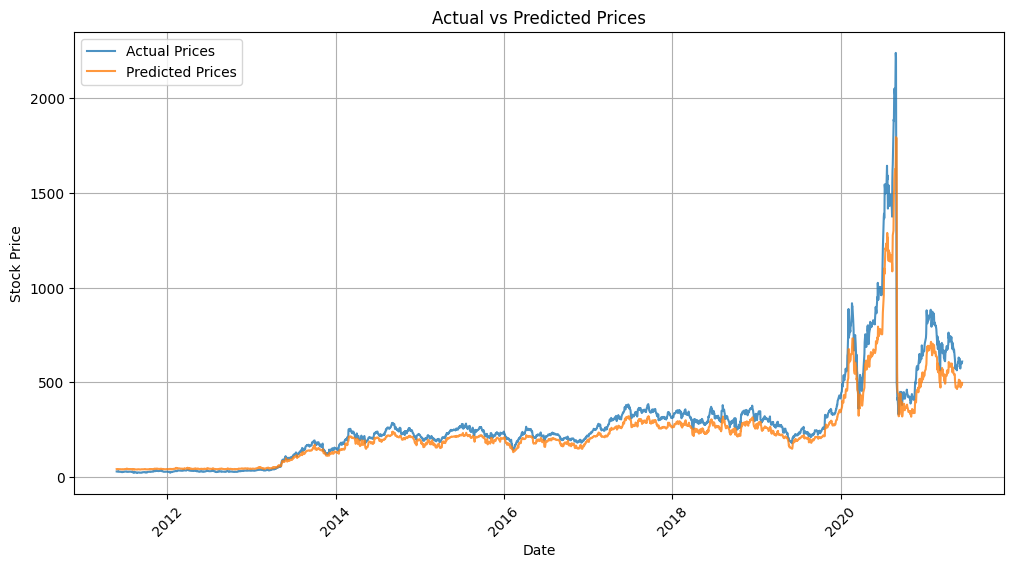

(array([ 29.48,  29.55,  30.14, ..., 598.78, 610.12, 609.89]),
 array([ 41.87200632,  42.22248533,  42.11519449, ..., 487.89945216,
        484.96989691, 497.0797559 ]))

In [180]:
evaluate_model_on_ticker("TSLA", seventh_model)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


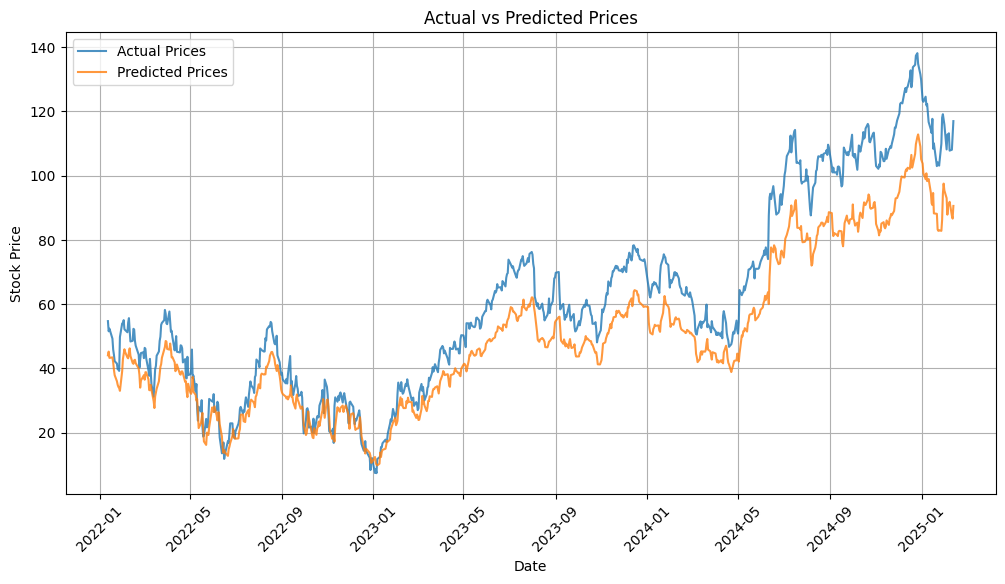

169.49350479760278


In [181]:
dates, y_sequence_rescaled, y_pred_rescaled = get_sequences_and_predict('AAPL', data, numerical_columns, sequence_length, seventh_model)
plot_actual_vs_predicted(dates, y_sequence_rescaled, y_pred_rescaled)
print(mean_squared_error(y_sequence_rescaled, y_pred_rescaled))

In [183]:
mse_df, average_mse = calculate_mse_for_stocks(seventh_model)
print('Average MSE: ', average_mse)
display(mse_df)


Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Processing ticker: 0
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Average MSE:  143.81364334227445


,Stock,MSE
0,NVDA,159.529076
1,AAPL,169.493468
2,FL,189.349543
3,NKE,112.726552
4,HPE,146.148679
5,PYPL,33.875637
6,AMD,155.651713
7,VOO,183.734479


We can observe, that the model is performing much better, than everything we have seen. The error is still on the high side for real money scenarios, but it wasn't expected to predict them 100% correctly. It almost manages to predict it perfectly.

## 5. Conclusion

The project explored the application of LSTM networks for stock price prediction using historic stock data and technical indicators. The model was improved over multiple interations with different optimization and issues found.

The initial models suffer from incorrect feature scaling, suboptimal loss functions and architectural choices. Through systematic experimentations, there were many improvements made:

- The use of separate scalers for price-related features and technical indeicators` was a crucial step for the accurate prediction.
- Remove unnecessary features, that did not contribute to the prediction accuracy.
- Implement Batch Normalization after LSTM layers to stabilize training and improve generalization.
- Experiment with different loss functions and concluding MSE is better suited for stock price prediction as Huber is too conservative and led to big underestimations.
- Testing attention mechanisms, which were later removed, since they didn't improve the results and even worsened them.
- Introducting data batching for efficient memory management and a lot faster model training, so that we can get to later epochs faster and easier.

The final model was far from perfect, but successfully captures short term price trends with a bit of underestimation trend. It correctly follows the market movements for different tickers. Future work could integrate market sentiment analysis, economic indicators and maybe experiment with alternative architectures for further enchancing the prediction accuracy. Also we could try improving the model to predict not only one day in the future, but one week or maybe even a month, using the already predicted data. It will be a difficult task to do such predictions though, since the stock market is very volatile and is moving a different directions on a daily basis. 

Overall this project demonstrated the feasibility of deep learning for stock market forecasting, highlighting the dchallenges and the importance of model selection and data processing during deep learning processes.

## Bibliography

[1] Moghar, A., & Hamiche, M. (2020). Stock Market Prediction Using LSTM Recurrent Neural Network. Procedia Computer Science, 170, 1168–1173. https://www.sciencedirect.com/science/article/pii/S1877050920304865

[2] Kavinnilaa J., Hemalatha E., Minu Susan Jacob, Dhanalakshmi R. (2021). 2021 IEEE conference. Stock Price Prediction Based on LSTM Deep Learning Model. https://ieeexplore.ieee.org/document/9526491

[3] Ruobing Zhang. (2022). LSTM-based Stock Prediction Modeling and Analysis. In Proceedings of the 2022 7th International Conference on Financial Innovation and Economic Development (ICFIED 2022) (pp. 2537–2542). Atlantis Press. https://www.atlantis-press.com/proceedings/icfied-22/125971905

[4] NVIDIA Developer. (n.d.). Long Short-Term Memory (LSTM). NVIDIA. https://developer.nvidia.com/discover/lstm

[5] Shipra Saxena. (2024, November 9). Introduction to Batch Normalization. https://www.analyticsvidhya.com/blog/2021/03/introduction-to-batch-normalization/

[6] Dr. Ernesto Lee, (2024, April 8). Advanced Stock Pattern Prediction using LSTM with the Attention Mechanism in TensorFlow: A step by step Guide with Apple Inc. (AAPL) Data. https://drlee.io/advanced-stock-pattern-prediction-using-lstm-with-the-attention-mechanism-in-tensorflow-a-step-by-143a2e8b0e95

[7] Bohsun Chen. (2024). Understanding Huber Loss Function: Insights from Applications. Medium. https://medium.com/@devcharlie2698619/understanding-huber-loss-function-insights-from-applications-5c1c5145d2c4